# Test beam analysis

### Necessary Imports

In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import norm, moyal
from scipy.signal import find_peaks

pd.options.display.max_columns = 500
pd.options.display.max_rows = 100000

### Read the nTuple data into a Pandas DataFrame

In [2]:
def ntuple_to_pd(filename):
    
    # Open the TTree anaTree and get all keys
    events = uproot.open("{}:anaTree".format(filename))
    main_keys = events.keys()
    
    # Construct the analysis dataframe
    df = pd.DataFrame()
    for key in main_keys:
        
        # Skip the nChannels key
        if(key == 'nChannels'):
            continue

        arr = events[key].array(library='np').squeeze()

        # Convert the array to a DataFrame
        df_key = pd.DataFrame(arr)

        # Rename the columns to include the key name
        df_key.columns = [f"{key}{i}" for i in df_key.columns]

        # Concatenate the new DataFrame to the existing one
        df = pd.concat([df, df_key], axis=1)
        
    return df

### Runs 670 - 677: Trigger T0 and T2 Coincidence with Hodoscope OR Lead Glass - 1% Slit
#### Please note that ntuples 672 (700 MeV), 674 (900 MeV), 675 (1 GeV) and 716 (700 MeV) cannot be produced with Nick script. This is something that may need to be considered.

In [3]:
# Convert the ROOT file to a CSV
run  = "000734"
path = "../ntuples/ntuple_"
df   = ntuple_to_pd(path + "{}.root".format(run))

In [4]:
df.head(100)

,Pedestal0,Pedestal1,Pedestal2,Pedestal3,Pedestal4,Pedestal5,Pedestal6,Pedestal7,Pedestal8,Pedestal9,Pedestal10,Pedestal11,Pedestal12,Pedestal13,Pedestal14,Pedestal15,Pedestal16,Pedestal17,Pedestal18,Pedestal19,Pedestal20,Pedestal21,Pedestal22,Pedestal23,Pedestal24,Pedestal25,Pedestal26,Pedestal27,Pedestal28,Pedestal29,Pedestal30,Pedestal31,PedestalSigma0,PedestalSigma1,PedestalSigma2,PedestalSigma3,PedestalSigma4,PedestalSigma5,PedestalSigma6,PedestalSigma7,PedestalSigma8,PedestalSigma9,PedestalSigma10,PedestalSigma11,PedestalSigma12,PedestalSigma13,PedestalSigma14,PedestalSigma15,PedestalSigma16,PedestalSigma17,PedestalSigma18,PedestalSigma19,PedestalSigma20,PedestalSigma21,PedestalSigma22,PedestalSigma23,PedestalSigma24,PedestalSigma25,PedestalSigma26,PedestalSigma27,PedestalSigma28,PedestalSigma29,PedestalSigma30,PedestalSigma31,nPeaks0,nPeaks1,nPeaks2,nPeaks3,nPeaks4,nPeaks5,nPeaks6,nPeaks7,nPeaks8,nPeaks9,nPeaks10,nPeaks11,nPeaks12,nPeaks13,nPeaks14,nPeaks15,nPeaks16,nPeaks17,nPeaks18,nPeaks19,nPeaks20,nPeaks21,nPeaks22,nPeaks23,nPeaks24,nPeaks25,nPeaks26,nPeaks27,nPeaks28,nPeaks29,nPeaks30,nPeaks31,PeakVoltage0,PeakVoltage1,PeakVoltage2,PeakVoltage3,PeakVoltage4,PeakVoltage5,PeakVoltage6,PeakVoltage7,PeakVoltage8,PeakVoltage9,PeakVoltage10,PeakVoltage11,PeakVoltage12,PeakVoltage13,PeakVoltage14,PeakVoltage15,PeakVoltage16,PeakVoltage17,PeakVoltage18,PeakVoltage19,PeakVoltage20,PeakVoltage21,PeakVoltage22,PeakVoltage23,PeakVoltage24,PeakVoltage25,PeakVoltage26,PeakVoltage27,PeakVoltage28,PeakVoltage29,PeakVoltage30,PeakVoltage31,PeakTime0,PeakTime1,PeakTime2,PeakTime3,PeakTime4,PeakTime5,PeakTime6,PeakTime7,PeakTime8,PeakTime9,PeakTime10,PeakTime11,PeakTime12,PeakTime13,PeakTime14,PeakTime15,PeakTime16,PeakTime17,PeakTime18,PeakTime19,PeakTime20,PeakTime21,PeakTime22,PeakTime23,PeakTime24,PeakTime25,PeakTime26,PeakTime27,PeakTime28,PeakTime29,PeakTime30,PeakTime31,SignalTime0,SignalTime1,SignalTime2,SignalTime3,SignalTime4,SignalTime5,SignalTime6,SignalTime7,SignalTime8,SignalTime9,SignalTime10,SignalTime11,SignalTime12,SignalTime13,SignalTime14,SignalTime15,SignalTime16,SignalTime17,SignalTime18,SignalTime19,SignalTime20,SignalTime21,SignalTime22,SignalTime23,SignalTime24,SignalTime25,SignalTime26,SignalTime27,SignalTime28,SignalTime29,SignalTime30,SignalTime31,IntCharge0,IntCharge1,IntCharge2,IntCharge3,IntCharge4,IntCharge5,IntCharge6,IntCharge7,IntCharge8,IntCharge9,IntCharge10,IntCharge11,IntCharge12,IntCharge13,IntCharge14,IntCharge15,IntCharge16,IntCharge17,IntCharge18,IntCharge19,IntCharge20,IntCharge21,IntCharge22,IntCharge23,IntCharge24,IntCharge25,IntCharge26,IntCharge27,IntCharge28,IntCharge29,IntCharge30,IntCharge31
0,9.571535,9.598426,9.526861,9.454739,9.254609,9.332795,9.500472,9.603869,9.474295,9.559813,9.551889,9.508464,9.628413,9.521167,9.611495,9.557544,9.530401,9.531130,9.538953,9.502081,9.624865,9.469984,9.650597,9.616759,9.636620,9.744997,9.709194,9.743859,9.583721,9.611653,9.636563,9.641043,0.087318,0.065865,0.034074,0.026852,0.011579,0.010544,0.023986,0.001735,0.018473,0.011586,0.086891,0.187640,0.059977,0.241358,0.012935,0.110710,0.045396,0.002356,0.003311,0.002097,0.002017,0.002338,0.001979,0.002108,0.002224,0.002206,0.002004,0.002317,0.002237,0.002229,0.002000,0.001990,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,7.0,3.0,2.455239,9.326187,0.038097,1.186461,0.022533,0.027936,0.449330,0.002976,4.815490,3.743676,2.755171,4.294266,4.565793,6.400963,6.554107,7.969926,2.347672,0.008279,3.439680,0.024536,0.004980,0.006197,0.005741,0.004829,0.009898,0.006068,0.005490,0.005698,0.007310,0.007313,0.006556,0.007683,161.0,135.0,135.0,131.0,189.0,103.0,173.0,41.0,69.0,63.0,69.0,65.0,83.0,81.0,83.0,81.0,137.0,113.0,91.0,93.0,103.0,125.0,155.0,199.0,53.0,93.0,31.0,31.0,193.0,25.0,151.0,23.0,152.737939,125.304819,131.284338,124.421917,187.131349,101.019202,167.169088,39.349804,64.330122,63.724621,64.324855,64.111283,76.405997,76.705943,7

## Peak time analysis

In [5]:
# Create entries in dataframe for averages in peak times
df['PeakTimeACT0'] = (df['PeakTime0'] + df['PeakTime1'])/2
df['PeakTimeACT1'] = (df['PeakTime2'] + df['PeakTime3'])/2
df['PeakTimeACT3'] = (df['PeakTime4'] + df['PeakTime5'])/2
df['PeakVoltageACT3'] = (df['PeakVoltage4'] + df['PeakVoltage5'])/2
df['PeakTimeTOF0'] = (df['PeakTime8'] + df['PeakTime9'] + df['PeakTime10'] + df['PeakTime11'])/4
df['PeakTimeTOF1'] = (df['PeakTime12'] + df['PeakTime13'] + df['PeakTime14'] + df['PeakTime15'])/4

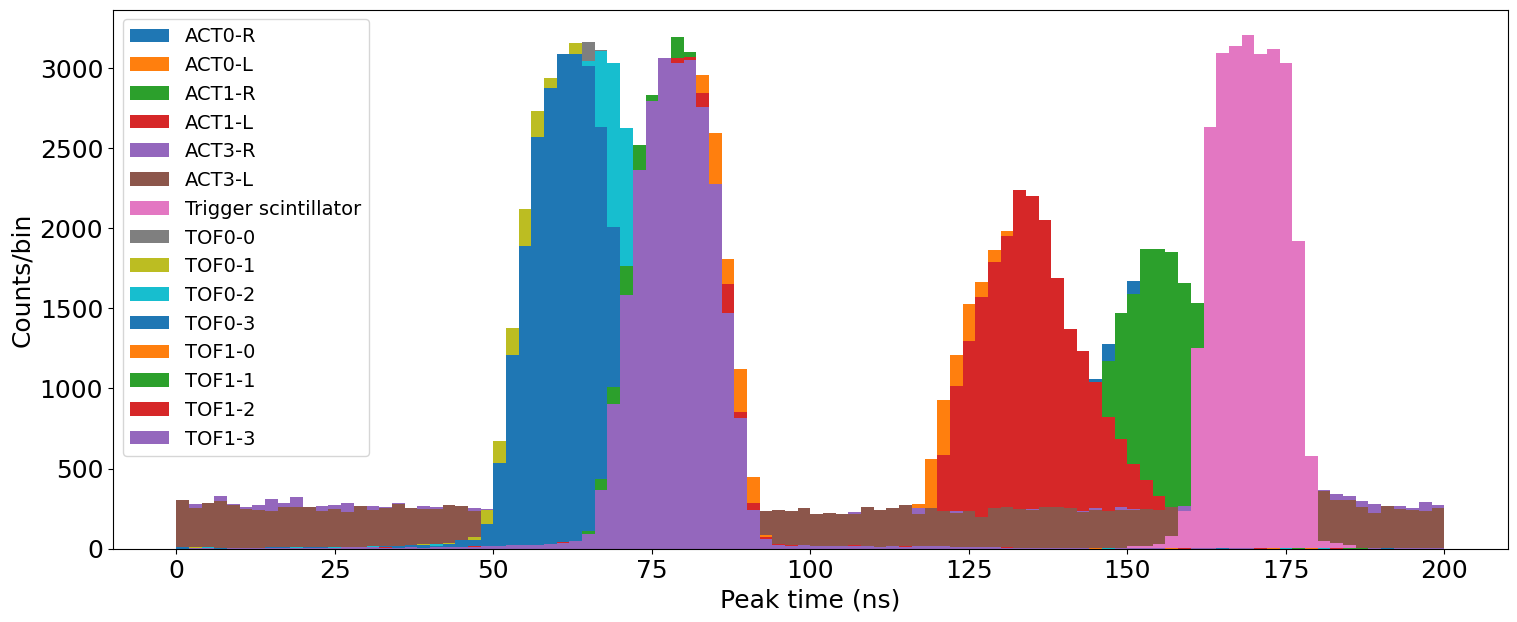

In [20]:
rng_time = [0,200]
nbins_time = 100

fig = plt.figure(figsize=(18,7))

h_ACT0R = plt.hist(df['PeakTime0'],bins=nbins_time,range=rng_time,label="ACT0-R")
h_ACT0L = plt.hist(df['PeakTime1'],bins=nbins_time,range=rng_time,label="ACT0-L")
h_ACT1L = plt.hist(df['PeakTime2'],bins=nbins_time,range=rng_time,label="ACT1-R")
h_ACT1R = plt.hist(df['PeakTime3'],bins=nbins_time,range=rng_time,label="ACT1-L")
h_ACT3L = plt.hist(df['PeakTime4'],bins=nbins_time,range=rng_time,label="ACT3-R")
h_ACT3R = plt.hist(df['PeakTime5'],bins=nbins_time,range=rng_time,label="ACT3-L")

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="Trigger scintillator")

h_TOF00 = plt.hist(df['PeakTime8'],bins=nbins_time,range=rng_time,label='TOF0-0')
h_TOF01 = plt.hist(df['PeakTime9'],bins=nbins_time,range=rng_time,label='TOF0-1')
h_TOF02 = plt.hist(df['PeakTime10'],bins=nbins_time,range=rng_time,label='TOF0-2')
h_TOF03 = plt.hist(df['PeakTime11'],bins=nbins_time,range=rng_time,label='TOF0-3')

h_TOF10 = plt.hist(df['PeakTime12'],bins=nbins_time,range=rng_time,label='TOF1-0')
h_TOF11 = plt.hist(df['PeakTime13'],bins=nbins_time,range=rng_time,label='TOF1-1')
h_TOF12 = plt.hist(df['PeakTime14'],bins=nbins_time,range=rng_time,label='TOF1-2')
h_TOF13 = plt.hist(df['PeakTime15'],bins=nbins_time,range=rng_time,label='TOF1-3')

plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=14)
plt.savefig("peak_times.png", bbox_inches='tight')

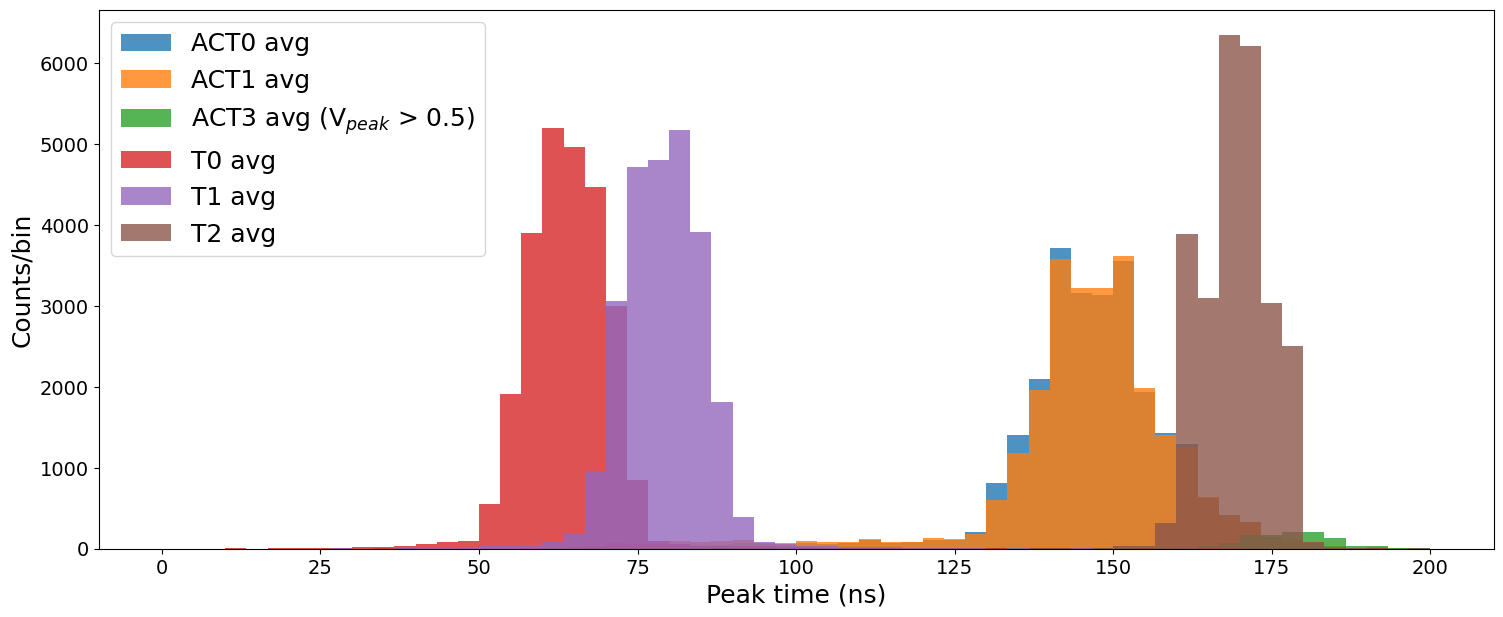

In [21]:
rng_time = [0,200]
nbins_time = 60
alpha_time = 0.8

fig = plt.figure(figsize=(18,7))

h_ACT0 = plt.hist(df['PeakTimeACT0'],bins=nbins_time,range=rng_time,label="ACT0 avg",alpha=alpha_time)
h_ACT1 = plt.hist(df['PeakTimeACT1'],bins=nbins_time,range=rng_time,label="ACT1 avg",alpha=alpha_time)
h_ACT3 = plt.hist(df[df['PeakVoltageACT3'] > 0.5]['PeakTimeACT3'],bins=nbins_time,range=rng_time,label="ACT3 avg (V$_{peak}$ > 0.5)",alpha=alpha_time)

h_TOF0 = plt.hist(df['PeakTimeTOF0'],bins=nbins_time,range=rng_time,label='T0 avg',alpha=alpha_time)
h_TOF1 = plt.hist(df['PeakTimeTOF1'],bins=nbins_time,range=rng_time,label='T1 avg',alpha=alpha_time)

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="T2 avg",alpha=alpha_time)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=18)
plt.savefig("peak_times_avg.png", bbox_inches='tight')

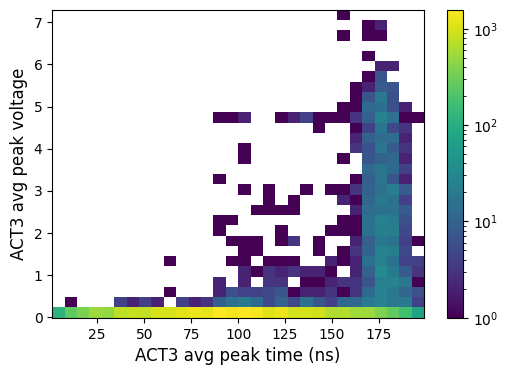

In [28]:
fig, ax = plt.subplots(figsize=(6,4))
h2_ACT3 = ax.hist2d(df['PeakTimeACT3'],df['PeakVoltageACT3'],bins=[30,30],norm=matplotlib.colors.LogNorm())
fig.colorbar(h2_ACT3[3],ax=ax)
plt.xlabel("ACT3 avg peak time (ns)",fontsize=12)
plt.ylabel("ACT3 avg peak voltage",fontsize=12)
plt.savefig("ACT3_voltage_vs_time.png", bbox_inches='tight')

## Hodoscope analysis
#### These cuts allow us to see the individual peaks in the LGCharge plot below
#### Please note these cuts are made just looking at the charge spectrum of the LG and the Hodoscope PMTs and cutting the tail, but perhaps this tail could be eliminated using cuts in the Aerogels (?)

In [ ]:
th_hd = 0.02
cut_LG  = (df['IntCharge16'] > 0.05)

cut_H0 =  df['IntCharge24'] > th_hd
cut_H1 =  df['IntCharge25'] > th_hd
cut_H2 =  df['IntCharge26'] > th_hd
cut_H3 =  df['IntCharge27'] > th_hd
cut_H4 =  df['IntCharge28'] > th_hd
cut_H5 =  df['IntCharge29'] > th_hd
cut_H6 =  df['IntCharge30'] > th_hd
cut_H7 =  df['IntCharge31'] > th_hd
cut_H8 =  df['IntCharge17'] > th_hd
cut_H9 =  df['IntCharge18'] > th_hd
cut_H10 = df['IntCharge19'] > th_hd
cut_H11 = df['IntCharge20'] > th_hd
cut_H12 = df['IntCharge21'] > th_hd
cut_H13 = df['IntCharge22'] > th_hd
cut_H14 = df['IntCharge23'] > th_hd

LG_cal = 1. #120/3.
#rng = [0, 500*3/120]
rng = [0.0, 1.5]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)
  
 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);

## Fitting the Lead Glass Charge Peaks (HodosCope Peaks)
#### Just a regular gaussian fit using Scipy CurveFit

In [ ]:
from scipy.stats import norm
from scipy.optimize import curve_fit

In [ ]:
data_H14 = df[cut_H14 & cut_LG]['IntCharge16']*LG_cal
data_H13 = df[cut_H13 & cut_LG]['IntCharge16']*LG_cal
data_H12 = df[cut_H12 & cut_LG]['IntCharge16']*LG_cal
data_H11 = df[cut_H11 & cut_LG]['IntCharge16']*LG_cal
data_H10 = df[cut_H10 & cut_LG]['IntCharge16']*LG_cal
data_H9  = df[cut_H9  & cut_LG]['IntCharge16']*LG_cal
data_H8  = df[cut_H8  & cut_LG]['IntCharge16']*LG_cal
data_H7  = df[cut_H7  & cut_LG]['IntCharge16']*LG_cal
data_H6  = df[cut_H6  & cut_LG]['IntCharge16']*LG_cal
data_H5  = df[cut_H5  & cut_LG]['IntCharge16']*LG_cal
data_H4  = df[cut_H4  & cut_LG]['IntCharge16']*LG_cal
data_H3  = df[cut_H3  & cut_LG]['IntCharge16']*LG_cal
data_H2  = df[cut_H2  & cut_LG]['IntCharge16']*LG_cal
data_H1  = df[cut_H1  & cut_LG]['IntCharge16']*LG_cal
data_H0  = df[cut_H0  & cut_LG]['IntCharge16']*LG_cal

datas = [data_H0, data_H1, data_H2, data_H3, data_H4, 
         data_H5, data_H6, data_H7, data_H8, data_H9, 
         data_H10, data_H11, data_H12, data_H13, data_H14]

labels = ["H0", "H1", "H2", "H3", "H4", "H5", "H6", "H7", "H8", "H9", "H10", "H11", "H12", "H13", "H14"]

### This is not automated, you need to chage some values as you change the run, such as h, h decreasing and the text positioning since the counts decrease with the beam momentum

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))
h = 1400
means = []

for i,j in zip(datas, labels):    
    data = i

    hist, bin_edges = np.histogram(data, bins='auto') 

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    def gaussian(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

    # Parámetros iniciales para el ajuste (estimaciones iniciales)
    initial_params = [1.0, 0.0, 1.0]

    # Realiza el ajuste
    popt, _ = curve_fit(gaussian, bin_centers, hist, p0=initial_params)

    # Crea una curva con los parámetros ajustados
    fit_curve = gaussian(bin_centers, *popt)

    # Grafica el histograma y la curva ajustada
    plt.hist(data, bins='auto', alpha=0.6, label=j);
    plt.plot(bin_centers, fit_curve, 'r-', alpha=0.6)
    plt.text(0.9, h, 'StdDev/Mean {}: {:.2f}'.format(j, popt[2]/popt[1]),fontsize=15)

    plt.legend()
    
    plt.xlabel('Lead Glass (charge)',fontsize=20);
    plt.ylabel('Counts/bin',fontsize=20);
    plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);
    
    plt.xlim(0., 1.5)
    
    h -= 87
    means.append(popt[1])

    print('Valores del ajuste para {}:'.format(j))
    print('Mean: {:.2f}'.format(popt[1]))
    print('StdDev: {:.2f}'.format(popt[2]))
    print(' ')

# Try fitting just a determined range

In [ ]:
#fig, ax = plt.subplots(figsize=(12, 6.0))
#h = 500
#
#for i,j in zip(datas, labels):    
#    data = i
#
#    hist, bin_edges = np.histogram(data, bins='auto') 
#
#    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#
#    def gaussian(x, amplitude, mean, stddev):
#        return amplitude * norm.pdf(x, loc=mean, scale=stddev)
#    
#    # Limita los datos y el eje x hasta cierto valor máximo (por ejemplo, x = 6)
#    max_x_value = 2.2
#    mask = bin_centers <= max_x_value
#    filtered_x = bin_centers[mask]
#    filtered_hist = hist[mask]
#
#
#    # Parámetros iniciales para el ajuste (estimaciones iniciales)
#    initial_params = [1.0, 0.0, 1.0]
#
#    # Realiza el ajuste
#    popt, _ = curve_fit(gaussian, filtered_x, filtered_hist, p0=initial_params)
#
#    # Crea una curva con los parámetros ajustados
#    fit_curve = gaussian(filtered_x, *popt)
#
#    # Grafica el histograma y la curva ajustada
#    plt.hist(data, bins='auto', alpha=0.6, label=j);
#    plt.plot(filtered_x, fit_curve, 'r-', alpha=0.6)
#    plt.text(2.15, h, 'StdDev {}: {:.2f}'.format(j, popt[2]),fontsize=15)
#
#    plt.legend()
#    
#    plt.xlabel('Counts/bin',fontsize=20);
#    plt.ylabel('Lead Glass (charge)',fontsize=20);
#    plt.title("Run {}, p = +800 MeV/c".format(run),fontsize=20);
#    
#    plt.xlim(0.4, 3.2)
#    
#    h -= 27
#
#    #print('Valores del ajuste:')
#    #print('Amplitude: {:.2f}'.format(popt[0]))
#    #print('Mean: {:.2f}'.format(popt[1]))
#    #print('StdDev: {:.2f}'.format(popt[2]))

# 2D Plot Expected Tagged Photon Energy vs. Lead Glass Charge

#### hit_energy values are the "expected gamma energy", computed by Josh

In [ ]:
hit_energy = [0.1595155500109545, 0.16918666630815957, 0.17050944491673403, 0.18508668641801915,
             0.1883263228952287, 0.20450156481839696, 0.21056117899451413, 0.22867222330704012,
             0.23899202319688614, 0.25950074031219433, 0.27649806820124223, 0.30005667059694635,
             0.32806001869009743, 0.3556345402074757, 0.40311754765565394]

#### IMPORTANT: Please note that you need to change the run momentum in this next cell

In [ ]:
run_momentum = 500

actual_means = means[::-1]
e_gamma_expected = [run_momentum - i*1000 for i in hit_energy[::-1]]

In [ ]:
plt.scatter(actual_means, e_gamma_expected);

plt.xlabel('Lead Glass Charge [Arbitrary Unit]');
plt.ylabel('Tagged Photon Expected Momentum [MeV/c]');

plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);

# Aerogel Charged Particle Veto
#### Akira suggested we could use Aerogel 3 as charged particle veto ensuring only non-charged particles pass through it. Aerogels 0 & 1 can be used as veto in the opposite way. These could make us get rid of the tails that appear as beam momentum increases (see peak plots for 1200 MeV)

In [ ]:
plt.hist(df['IntCharge4'], bins=40, alpha=0.7);
plt.hist(df['IntCharge5'], bins=40, alpha=0.7);

plt.yscale('log');

plt.xlabel('Aerogel 3R & 3L Charge [Arbitrary Unit]');
plt.ylabel('Counts/bins');

In [ ]:
fig = plt.figure(figsize=(18,7))

ax1 = fig.add_subplot(121)
ax1.hist(df['IntCharge0'], bins=40, alpha=0.7, label='AG0R');
ax1.hist(df['IntCharge1'], bins=40, alpha=0.7, label='AG0L');

ax1.set_yscale('log');

ax1.set_xlabel('Aerogel 0R & 0L Charge [Arbitrary Unit]');
ax1.set_ylabel('Counts/bins');
plt.legend();

ax2 = fig.add_subplot(122)
ax2.hist(df['IntCharge2'], bins=40, alpha=0.7, label='AG1R');
ax2.hist(df['IntCharge3'], bins=40, alpha=0.7, label='AG1L');

ax2.set_yscale('log');

ax2.set_xlabel('Aerogel 1R & 1L Charge [Arbitrary Unit]');
ax2.set_ylabel('Counts/bins');
plt.legend();

#### Actual cuts for the aerogels. Many thresholds were tested and it seems like we cannot get rid of the tails using Aerogels.

In [ ]:
ag01_th = 0.0
ag3_th  = 0.1

cut_AG0R = df['IntCharge0'] > ag01_th
cut_AG0L = df['IntCharge1'] > ag01_th
cut_AG1R = df['IntCharge2'] > ag01_th
cut_AG1L = df['IntCharge3'] > ag01_th
cut_AG3R = df['IntCharge4'] < ag3_th
cut_AG3L = df['IntCharge5'] < ag3_th

cut_AG = cut_AG0R & cut_AG0L & cut_AG1R & cut_AG1L & cut_AG3R & cut_AG3L

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)

 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);